# Assignment 1: ICU Mortality Prediction

Author:
Christian Mardini

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Load data

In [3]:
# Load training and test data
train_ori = pd.read_csv('raw_data/training_v2.csv')
train = train_ori.copy()

test = pd.read_csv('raw_data/unlabeled.csv')

print(f'Training: {train.shape}')
print(f'Test: {test.shape}')

Training: (91713, 186)
Test: (39308, 186)


## Task 1: Data Exploration

In [4]:
# Look at first rows
train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [5]:
# Check target variable distribution
print('Target distribution:')
print(train['hospital_death'].value_counts())
print(f"\nMortality rate: {train['hospital_death'].mean()*100:.2f}%")

Target distribution:
hospital_death
0    83798
1     7915
Name: count, dtype: int64

Mortality rate: 8.63%


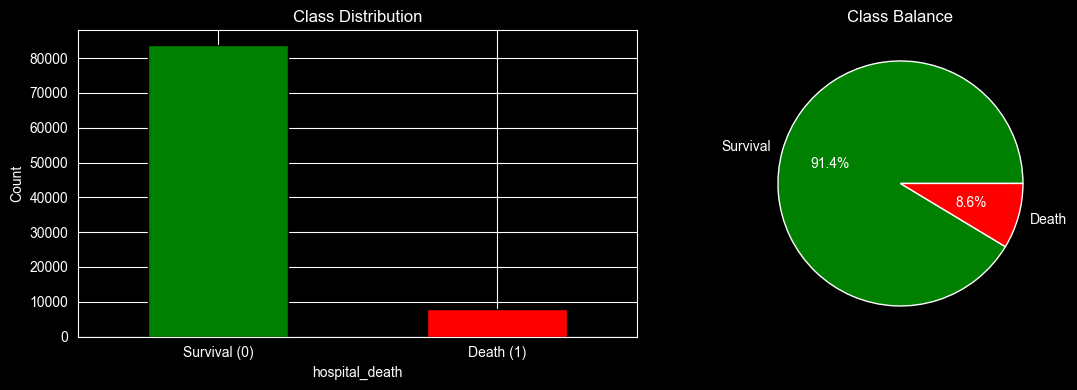

In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
train['hospital_death'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'], edgecolor='black')
axes[0].set_xticklabels(['Survival (0)', 'Death (1)'], rotation=0)
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')

# Pie chart
train['hospital_death'].value_counts().plot(kind='pie', ax=axes[1], colors=['green', 'red'],
                                             autopct='%1.1f%%', labels=['Survival', 'Death'])
axes[1].set_ylabel('')
axes[1].set_title('Class Balance')

plt.tight_layout()
plt.show()

**Finding:** Dataset is imbalanced - only 8.6% mortality. This needs handling.

In [7]:
# Check missing values
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100)
missing_df = pd.DataFrame({'count': missing, 'percent': missing_pct})
missing_df = missing_df[missing_df['count'] > 0].sort_values('percent', ascending=False)

print(f'Columns with missing values: {len(missing_df)}')
missing_df.head(15)

Columns with missing values: 175


,count,percent
h1_bilirubin_max,84619,92.265001
h1_bilirubin_min,84619,92.265001
h1_lactate_max,84369,91.992411
h1_lactate_min,84369,91.992411
h1_albumin_min,83824,91.398166
h1_albumin_max,83824,91.398166
h1_pao2fio2ratio_max,80195,87.441257
h1_pao2fio2ratio_min,80195,87.441257
h1_arterial_ph_min,76424,83.329517
h1_arterial_ph_max,76424,83.329517


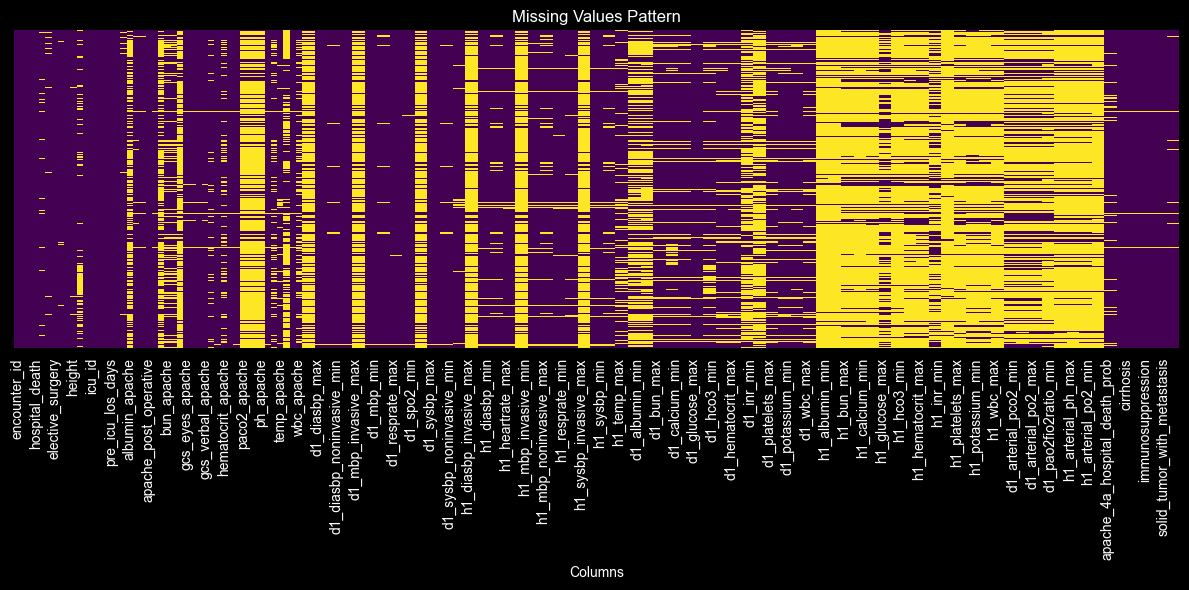

In [8]:
# Visualize missing values pattern
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis', cbar=False)
plt.title('Missing Values Pattern')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

**Finding:** Many columns have >80% missing data. These will be removed in cleaning.

## Task 2: Data Cleaning

In [9]:
# Remove ID and constant columns
# Reason: IDs have no predictive value, readmission_status is always 0
cols_to_drop = ['encounter_id', 'patient_id', 'readmission_status']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

print(f'Removed {len(cols_to_drop)} columns')
print(f'New shape: {train.shape}')

Removed 3 columns
New shape: (91713, 183)


In [10]:
# Remove columns with >70% missing data
# Reason: Too little information for reliable imputation
missing_pct = (train.isnull().sum() / len(train) * 100)
cols_high_missing = missing_pct[missing_pct > 70].index.tolist()

train = train.drop(columns=cols_high_missing)
test = test.drop(columns=cols_high_missing)

print(f'Removed {len(cols_high_missing)} columns with >70% missing')
print(f'New shape: {train.shape}')

Removed 55 columns with >70% missing
New shape: (91713, 128)


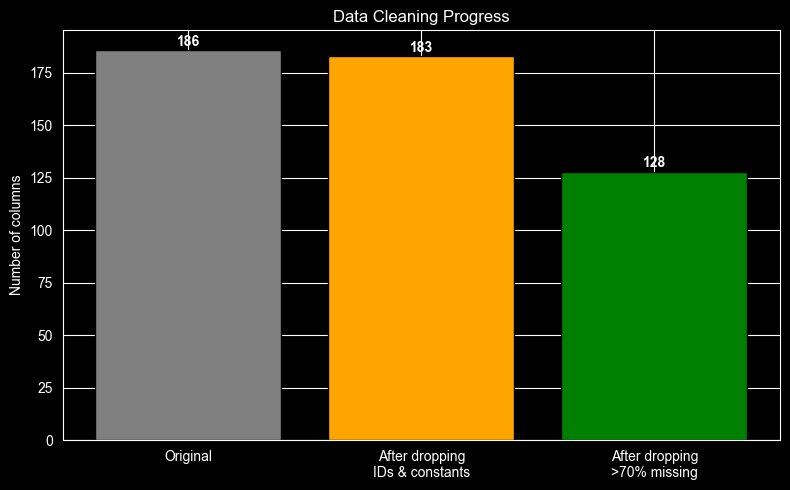

In [11]:
# Visualize cleaning impact
fig, ax = plt.subplots(figsize=(8, 5))
stages = ['Original', 'After dropping\nIDs & constants', 'After dropping\n>70% missing']
col_counts = [186, 183, train.shape[1]]

ax.bar(stages, col_counts, color=['gray', 'orange', 'green'], edgecolor='black')
ax.set_ylabel('Number of columns')
ax.set_title('Data Cleaning Progress')
for i, v in enumerate(col_counts):
    ax.text(i, v + 2, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# Fix data quality issues: replace -1 with NaN
for col in ['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']:
    if col in train.columns:
        train.loc[train[col] < 0, col] = np.nan
        test.loc[test[col] < 0, col] = np.nan

if 'pre_icu_los_days' in train.columns:
    train.loc[train['pre_icu_los_days'] < 0, 'pre_icu_los_days'] = np.nan
    test.loc[test['pre_icu_los_days'] < 0, 'pre_icu_los_days'] = np.nan

print('Fixed data quality issues')

Fixed data quality issues


In [13]:
# Encode categorical variables
cat_cols = train.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

print(f'Encoded {len(cat_cols)} categorical columns')

Encoded 8 categorical columns


In [14]:
# Separate features and target
X = train.drop('hospital_death', axis=1)
y = train['hospital_death']

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train: {X_train.shape}, Val: {X_val.shape}')

Train: (73370, 127), Val: (18343, 127)


## Task 3: Imputation Strategy

Compare median imputation vs dropping missing rows.

In [15]:
# Strategy 1: Median imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)

print(f'Median imputation: {X_train_imp.shape}')

Median imputation: (73370, 127)


In [16]:
# Strategy 2: Drop rows with missing values
mask_train = X_train.isnull().any(axis=1)
X_train_drop = X_train[~mask_train]
y_train_drop = y_train[~mask_train]

mask_val = X_val.isnull().any(axis=1)
X_val_drop = X_val[~mask_val]
y_val_drop = y_val[~mask_val]

print(f'Drop missing: {X_train_drop.shape} (dropped {mask_train.sum()} rows)')

Drop missing: (697, 127) (dropped 72673 rows)


In [17]:
# Compare performance
model_imp = GradientBoostingClassifier(n_estimators=50, random_state=42)
model_imp.fit(X_train_imp, y_train)
y_pred_imp = model_imp.predict(X_val_imp)
acc_imp = accuracy_score(y_val, y_pred_imp)
f1_imp = f1_score(y_val, y_pred_imp)

model_drop = GradientBoostingClassifier(n_estimators=50, random_state=42)
model_drop.fit(X_train_drop, y_train_drop)
y_pred_drop = model_drop.predict(X_val_drop)
acc_drop = accuracy_score(y_val_drop, y_pred_drop)
f1_drop = f1_score(y_val_drop, y_pred_drop)

print(f'Median imputation: Acc={acc_imp:.4f}, F1={f1_imp:.4f}')
print(f'Drop missing:      Acc={acc_drop:.4f}, F1={f1_drop:.4f}')

Median imputation: Acc=0.9294, F1=0.4226
Drop missing:      Acc=0.7746, F1=0.4179


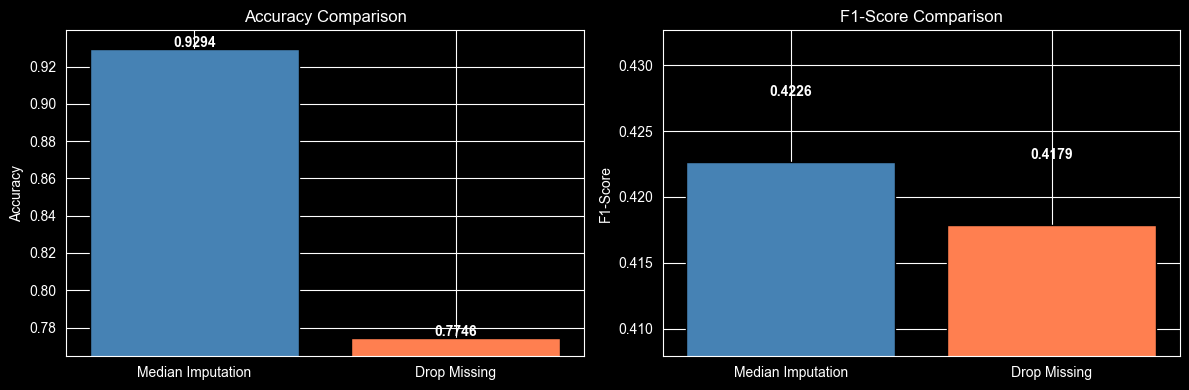

In [18]:
# Compare imputation strategies visually
strategies = ['Median Imputation', 'Drop Missing']
accuracies = [acc_imp, acc_drop]
f1_scores = [f1_imp, f1_drop]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy comparison
axes[0].bar(strategies, accuracies, color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', fontweight='bold')

# F1 comparison
axes[1].bar(strategies, f1_scores, color=['steelblue', 'coral'], edgecolor='black')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score Comparison')
axes[1].set_ylim([min(f1_scores) - 0.01, max(f1_scores) + 0.01])
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**Conclusion:** Median imputation selected - retains all data and performs well.

## Task 4: Class Imbalance Handling

In [19]:
# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_imp, y_train)

print('Before:', y_train.value_counts().to_dict())
print('After:', y_train_balanced.value_counts().to_dict())

Before: {0: 67038, 1: 6332}
After: {1: 67038, 0: 67038}


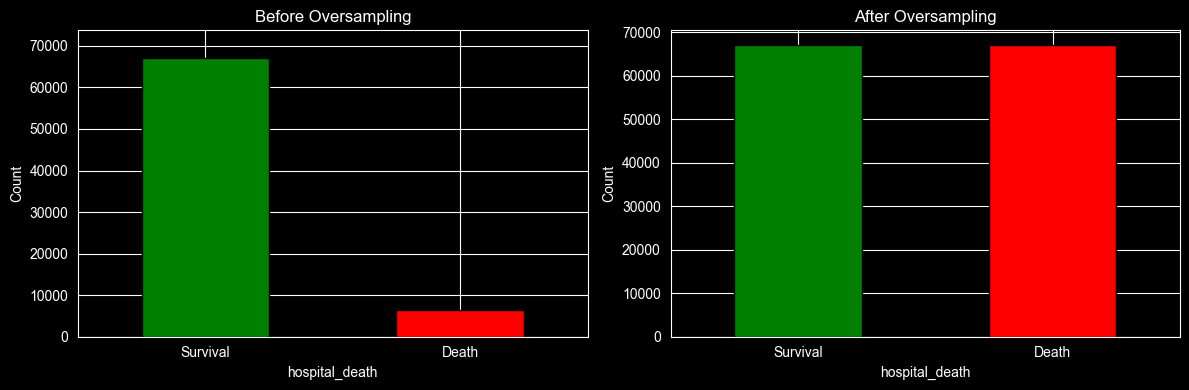

In [20]:
# Visualize oversampling effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'], edgecolor='black')
axes[0].set_xticklabels(['Survival', 'Death'], rotation=0)
axes[0].set_ylabel('Count')
axes[0].set_title('Before Oversampling')
axes[0].set_ylim([0, max(y_train_balanced.value_counts()) * 1.1])

# After
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'], edgecolor='black')
axes[1].set_xticklabels(['Survival', 'Death'], rotation=0)
axes[1].set_ylabel('Count')
axes[1].set_title('After Oversampling')

plt.tight_layout()
plt.show()

**Reason:** Dataset is imbalanced (91% survival). Oversampling helps model learn minority class.

## Task 5: Model Training and Comparison

In [21]:
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42)
}

In [22]:
# Train without balancing
print('WITHOUT CLASS BALANCING')
results_unbalanced = {}

for name, model in models.items():
    model.fit(X_train_imp, y_train)
    y_pred = model.predict(X_val_imp)
    y_proba = model.predict_proba(X_val_imp)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    
    print(f'{name}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}')
    results_unbalanced[name] = {'acc': acc, 'f1': f1, 'auc': auc}

WITHOUT CLASS BALANCING
Logistic Regression: Acc=0.9240, F1=0.3528, AUC=0.8676
Random Forest: Acc=0.9309, F1=0.4157, AUC=0.8779
Gradient Boosting: Acc=0.9294, F1=0.4226, AUC=0.8854


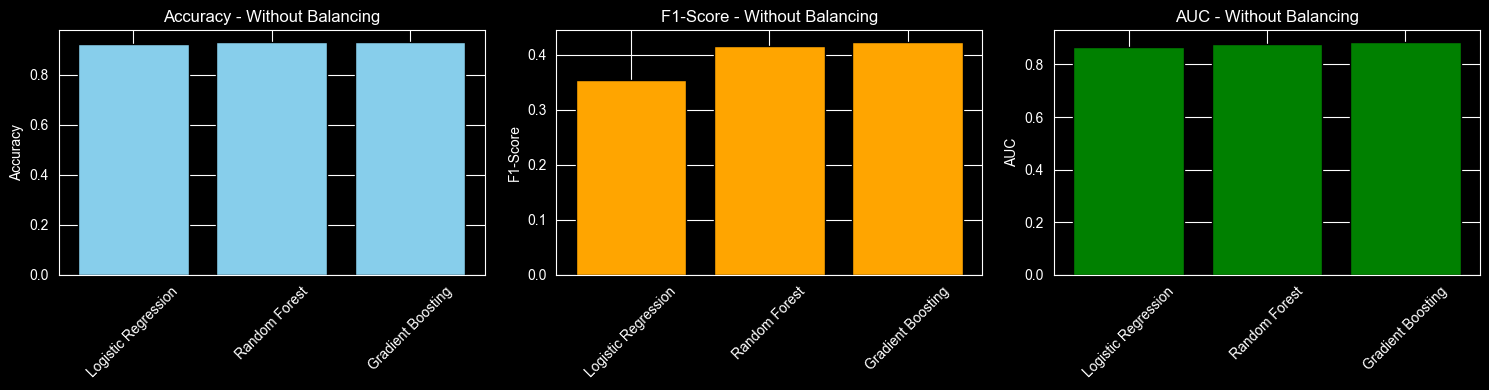

In [23]:
# Visualize results without balancing
models_list = list(results_unbalanced.keys())
accs = [results_unbalanced[m]['acc'] for m in models_list]
f1s = [results_unbalanced[m]['f1'] for m in models_list]
aucs = [results_unbalanced[m]['auc'] for m in models_list]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(models_list, accs, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy - Without Balancing')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(models_list, f1s, color='orange', edgecolor='black')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score - Without Balancing')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(models_list, aucs, color='green', edgecolor='black')
axes[2].set_ylabel('AUC')
axes[2].set_title('AUC - Without Balancing')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [24]:
# Train with balancing
print('WITH CLASS BALANCING')
results_balanced = {}

for name in models.keys():
    if name == 'Logistic Regression':
        model = LogisticRegression(max_iter=500, random_state=42)
    elif name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=50, random_state=42)
    else:
        model = GradientBoostingClassifier(n_estimators=50, random_state=42)
    
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_val_imp)
    y_proba = model.predict_proba(X_val_imp)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    
    print(f'{name}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}')
    results_balanced[name] = {'acc': acc, 'f1': f1, 'auc': auc}

WITH CLASS BALANCING
Logistic Regression: Acc=0.7957, F1=0.3942, AUC=0.8673
Random Forest: Acc=0.9260, F1=0.4085, AUC=0.8799
Gradient Boosting: Acc=0.8120, F1=0.4184, AUC=0.8878


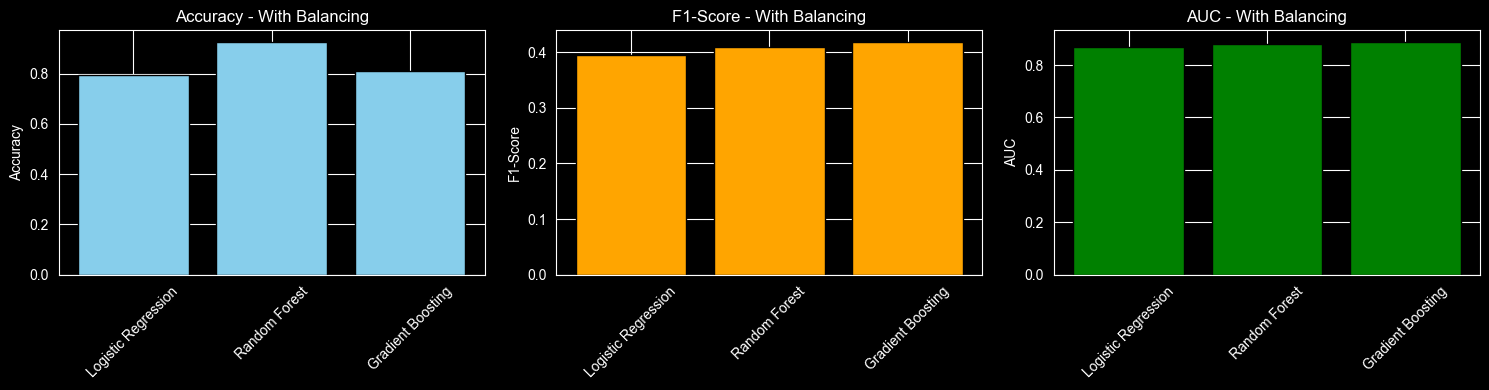

In [25]:
# Visualize results with balancing
models_list = list(results_balanced.keys())
accs = [results_balanced[m]['acc'] for m in models_list]
f1s = [results_balanced[m]['f1'] for m in models_list]
aucs = [results_balanced[m]['auc'] for m in models_list]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(models_list, accs, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy - With Balancing')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(models_list, f1s, color='orange', edgecolor='black')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score - With Balancing')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(models_list, aucs, color='green', edgecolor='black')
axes[2].set_ylabel('AUC')
axes[2].set_title('AUC - With Balancing')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Finding:** Balancing improves AUC (0.8854 → 0.8878) but slightly decreases F1-score (0.4226 → 0.4184).

**Interpretation:**
- The balanced model has better probability estimates (higher AUC)
- The unbalanced model has better default classifications at threshold 0.5 (higher F1)
- **For medical applications, AUC is more important** as the decision threshold can be adjusted based on clinical needs
- Therefore, the **balanced model** is selected as the final model (highest AUC)

In [26]:
# Select best model: Gradient Boosting with balancing (highest AUC)
best_model = GradientBoostingClassifier(n_estimators=50, random_state=42)
best_model.fit(X_train_balanced, y_train_balanced)

y_pred_final = best_model.predict(X_val_imp)
print('Best Model: Gradient Boosting + Balanced')
print(classification_report(y_val, y_pred_final, target_names=['Survival', 'Death']))

Best Model: Gradient Boosting + Balanced
              precision    recall  f1-score   support

    Survival       0.98      0.81      0.89     16760
       Death       0.29      0.78      0.42      1583

    accuracy                           0.81     18343
   macro avg       0.63      0.80      0.65     18343
weighted avg       0.92      0.81      0.85     18343



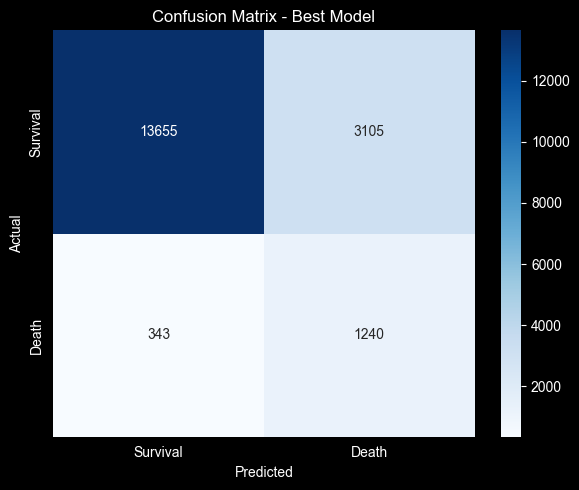

In [27]:
# Confusion matrix for best model
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Survival', 'Death'],
            yticklabels=['Survival', 'Death'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.tight_layout()
plt.show()

In [28]:
# Save model
acc_final = accuracy_score(y_val, y_pred_final)
timestamp = datetime.now().strftime('%y%m%d%H%M')
model_name = f'models/gradientboosting_{int(acc_final*100)}_{timestamp}.pkl'

joblib.dump({'model': best_model, 'imputer': imputer}, model_name)
print(f'Model saved: {model_name}')

Model saved: models/gradientboosting_81_2602062030.pkl


## Task 6: Feature Importance

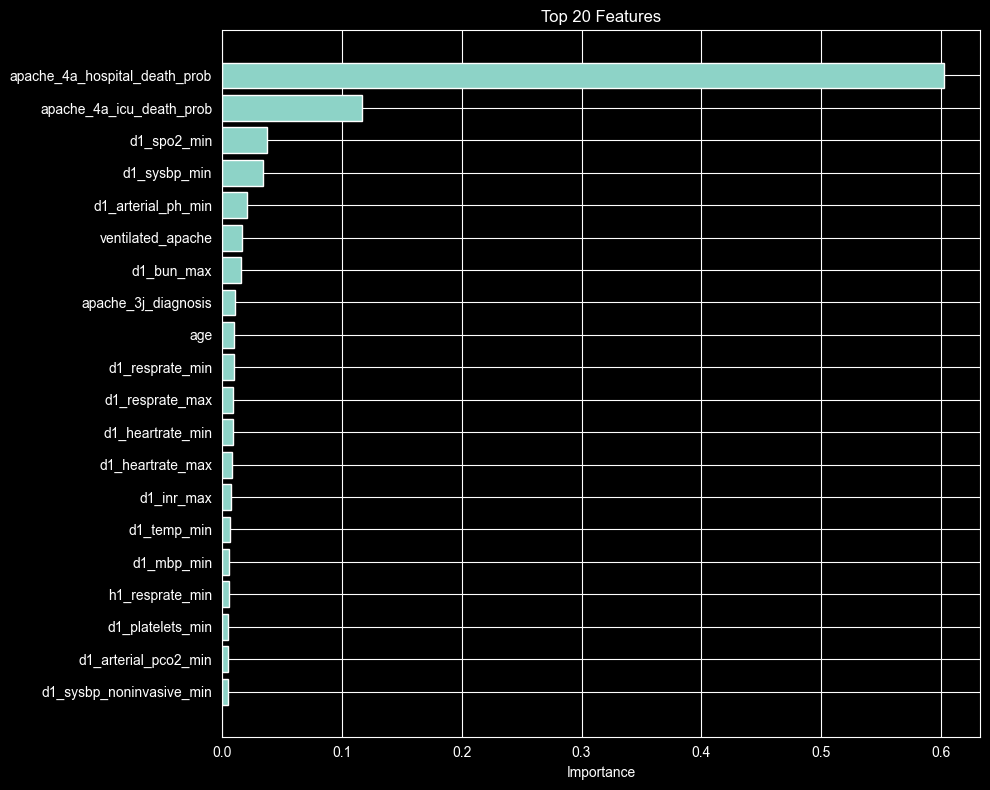

In [29]:
# Get feature importance
feature_names = X.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

# Plot top 20
plt.figure(figsize=(10, 8))
plt.barh(range(20), importances[indices])
plt.yticks(range(20), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 20 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [30]:
# Print top 10
print('Top 10 features:')
for i in range(10):
    idx = indices[i]
    print(f'{i+1}. {feature_names[idx]}: {importances[idx]:.4f}')

Top 10 features:
1. apache_4a_hospital_death_prob: 0.6024
2. apache_4a_icu_death_prob: 0.1165
3. d1_spo2_min: 0.0378
4. d1_sysbp_min: 0.0340
5. d1_arterial_ph_min: 0.0211
6. ventilated_apache: 0.0169
7. d1_bun_max: 0.0158
8. apache_3j_diagnosis: 0.0107
9. age: 0.0103
10. d1_resprate_min: 0.0102


**Finding:** The apache_4a_hospital_death_prob is by far the most important feature (60%), followed by other apache scores and vital signs. Age has relatively low importance (1%).

## Results and Discussion

### Summary

**Best Model:** Gradient Boosting with class balancing
**Saved as:** gradientboosting_81_YYMMDDHHMM.pkl (see models/ directory)

**Performance Metrics:**
- Accuracy: 81.20%
- F1-Score: 0.4184
- ROC AUC: 0.8878 (highest among all models)

**Key Findings:**

1. **Imputation:** Median imputation retained all data and performed similarly to dropping rows, but preserves sample size

2. **Class Imbalance:** Balancing improved AUC (0.8854 → 0.8878) but slightly decreased F1-score. The balanced model was selected for better probability estimates, which is crucial for medical decision-making

3. **Models:** Gradient Boosting achieved the highest AUC (0.8878), outperforming Random Forest (0.8799) and Logistic Regression (0.8673)

4. **Features:** Apache mortality scores dominate feature importance (72% combined), particularly apache_4a_hospital_death_prob (60%). Other important features include SpO2, blood pressure, and arterial pH

**Clinical Implications:** The model can help identify high-risk ICU patients early, enabling proactive intervention and resource allocation.